# Adaptive PDE discretizations on cartesian grids

## Part : Monotone numerical schemes
## Chapter : PDEs with a second order non-linearity

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of non-linear PDEs, in two space dimensions. 
We consider the operator
$$
    \Lambda u(x) := \alpha(x) \lambda_{\max}(\nabla^2 u(x)) + \lambda_{\min}(\nabla^2 u(x))
$$
in the PDE
$$
    - \Lambda u(x) + \beta(x) = 0,
$$
with Dirichlet boundary conditions. The PDE parameters are a positive function $\alpha$, and an arbitrary function $\beta$.
We denote by $\lambda_{\max}(M)$ and $\lambda_{\min}(M)$ the largest and smallest eigenvalue of a positive definite tensor $M$. More details on this problem below.

We design two monotone numerical schemes: 
* The first sheme, based on a discretization of the space of controls, is simple to implement. However it is quite costly numerically, and it induces a consistency defect.
* The second scheme is second order consistent and possibly cheaper numerically. However, implementation details are more subtle.

The two schemes involves adaptive stencils, built using techniques from lattice geometry. The techniques developed are fairly general, and can be applied to a wide range of non-linear PDEs. Numerical implementation is kept simple thanks to the use of automatic differentiation.

## Discretization of the PDE

### Reformulation as an extremal operator

Assume without loss of generality that $\alpha \leq 1$. Then for any positive definite matrix $M$ one has 
$$
    \alpha \lambda_{\max}(M) + \lambda_{\min}(M) = \min_{0 \leq \theta \leq \pi} {\rm tr}(D_\alpha(\theta) M),
$$
where we denoted, with $e(\theta) := (\cos \theta, \sin \theta)$
$$
    D_\alpha(\theta) = \alpha\, e(\theta) e(\theta)^T + e(\theta)^\perp (e(\theta)^\perp)^T,
$$
the symmetric matrix whose eigenvalues are $\alpha$ and $1$, the former associated with the eigenvector $e(\theta)$.

**Remark on the range of the variable $\theta$.**
For any $\theta\in \mathbb R$, one has $e(\theta+\pi) = -e(\theta)$, and therefore $D_\alpha(\theta+\pi) = D_\alpha(\theta)$. By periodicity, we may therefore limit our attention to the interval $[0,\pi]$.

**Remark on the case $\alpha\geq 1$.**
This second case is handled by replacing the minimum over $\theta\in [0,\pi]$ with a maximum. This does not induce any additional difficulty from the theoretical or numerical standpoints. However, for the sake of simplicity, we make the assumption that $\alpha\leq 1$ in the following.

### A monotone discretization strategy : sampling the control space

Let $K$ be a positive integer, and let $\theta_1 \leq \cdots \leq \theta_K$ be a sampling of the interval $[0,\pi]$. Then we may consider the approximate operator
$$
    \Lambda_K u(x) := \min_{1 \leq k \leq K} {\rm tr} (D_\alpha(\theta_k) \nabla^2 u(x)).
$$
Introduce decompositions of the tensors, obtained e.g. by Selling's method,
$$
    D_\alpha(\theta_k) = \sum_{1 \leq i \leq n} \mu_{ki} e_{ki} e_{ki}^T,
$$
where $\mu_{ki} \geq 0$ and $e_{ki}$ has integer coordinates. Then we obtain the monotone numerical scheme
$$
    \min_{1 \leq k \leq K} \sum_{1 \leq i \leq n} \mu_{ki} \frac{ u(x+h e_{ki}) - 2 u(x) +u(x-h e_{ki})} {h^2}.
$$
A consistency defect remains, which can be estimated in terms of the width of the sampling $\theta_1,\cdots,\theta_K$ of the control space $[0,\pi]$. 

An additional problem is that the numerical scheme cost increases as $K$ increases.
This issue becomes more acute in the case of a multi-dimensional control space.

### Another monotone and consistent discretization 

In order to introduce this discretization, we need to recall some elements from lattice geometry.
Selling's decomposition of a tensor $D$ involves a geometrical object, referred to as a *$D$-obtuse superbase* and here  denoted
$$
    {\rm osb}(D).
$$
The obtuse superbase $s={\rm osb}(D)$ dictates the support $(e_{si})_{i=1}^n$ of Selling's decomposition of $D$, hence the stencil of the numerical scheme. We can take advantage of this fact to rewrite the operator as 
$$
    \Lambda u(x) = \min_{s \in S} \Lambda_s u(x)
$$
where 
$$
    \Lambda_s u(x) := \min_{\theta, {\rm obs}(D_\alpha(\theta)) = s} {\rm tr} (D_\alpha(\theta) \nabla^2 u).
$$
Each operator $\Lambda_s$ admits the consistent discretization
$$
    \Lambda_s u(x) \approx \min_{\theta, {\rm obs}(D_\alpha(\theta)) = s} \sum_{1 \leq i \leq n} 
    \mu_{si}(\theta) \frac{u(x+h e_{si}) - 2 u(x) + u(x-e_{si})} {h^2}, 
$$
and a closed form can be obtained for the r.h.s. by examining a simple optimization problem.

In [5]:
import sys; sys.path.append("..") # Allow imports from parent directory

In [6]:
from Miscellaneous import TocTools; TocTools.displayTOC('NonlinearMonotoneSecond2D','NonDiv')

[**Summary**](Summary.ipynb) of this series of notebooks. 

[**Main summary**](../Summary.ipynb), including the other volumes of this work. 


# Table of contents

  * [1. Non-Monotone discretization (purposedly fails)](#1.-Non-Monotone-discretization-(purposedly-fails))
  * [2. Monotone discretization by sampling of the control space](#2.-Monotone-discretization-by-sampling-of-the-control-space)
    * [2.1 Limit case : $\alpha=1$.](#2.1-Limit-case-:-$\alpha=1$.)
    * [2.2 Limit case : $\alpha \to 0$](#2.2-Limit-case-:-$\alpha-\to-0$)
    * [2.3 Optimized implementation](#2.3-Optimized-implementation)
  * [3. Monotone and consistent discretization](#3.-Monotone-and-consistent-discretization)
    * [3.1 Angular sectors and obtuse superbases](#3.1-Angular-sectors-and-obtuse-superbases)
    * [3.2 Optimization over angular sector](#3.2-Optimization-over-angular-sector)




**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [7]:
from NumericalSchemes import Selling
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import FiniteDifferences as fd
from NumericalSchemes import AutomaticDifferentiation as ad

In [8]:
import numpy as np
import matplotlib.pyplot as plt

Some utility functions

In [9]:
def LInfNorm(a):
    return np.max(np.abs(np.array(a)))

def as_field(u,shape):
    ndim = len(shape)
    if u.ndim>=ndim and u.shape[-ndim:]==shape: return u
    else: return ad.broadcast_to(u.reshape(u.shape+(1,)*ndim), u.shape+shape)
    
def BoundaryNeighborhood(bc,width=1):
    bd = np.isnan(bc)
    bd[0,:]=False; bd[-1,:]=False; bd[:,0]=False; bd[:,-1]=False
    directions = ( (0,0),(0,1),(0,-1),(1,0),(-1,0) ) 
    neigh = np.stack(tuple(np.roll(bd,e,axis=(0,1)) for e in directions),axis=0)
    neigh = np.logical_and(neigh.any(axis=0),np.logical_not(neigh).any(axis=0))
    for i in range(width):
        neigh = np.stack(tuple(np.roll(neigh,e,axis=(0,1)) for e in directions),axis=0).any(axis=0)
    return neigh

In [10]:
def solve_Newton(Scheme,params,guess,print_period=1,niter=8,relax=0.):
    u = guess+ad.Sparse.identity(guess.shape)
    for i in range(niter):
        residue = Scheme(u,*params)
        if (i-1)%print_period ==0 or i==niter-1:
            print("Iteration :",i,", Residue norm :", LInfNorm(residue))
        u += (residue+relax).solve()
    return np.array(u)

In [11]:
def reload_packages():
    import importlib
    Selling = importlib.reload(sys.modules['NumericalSchemes.Selling'])
    lp = importlib.reload(sys.modules['NumericalSchemes.LinearParallel'])
    fd = importlib.reload(sys.modules['NumericalSchemes.FiniteDifferences'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.Sparse = importlib.reload(ad.Sparse)

## 1. Non-Monotone discretization (purposedly fails)

We present a naive, non-monotone discretization of the addressed problem. This scheme can be used to check that a numerical solution (produced by other means) is correct, or to construct synthetic examples. However, using it to solve the PDE is usually bound to fail. 

The naive scheme is based on a reconstruction of the Hessian matrix of the form
$$
    \begin{pmatrix}
        D^h_{00} u(x) & D^h_{01} u(x)\\
        D^h_{01} u(x) & D^h_{11} u(x)
    \end{pmatrix},
$$
where $D_{00}$, $D_{01}$ and $D_{11}$ are finite-difference operators. Namely
$$
    D^h_{00} u(x) := \frac{u(x_0+h,x_1)-2 u(x_0,x_1) + u(x_0-h,x_1)}{h^2},
$$
likewise for $D^h_{11} u(x)$, and finally
$$
    D^h_{01} u(x) := \frac{u(x_0+h,x_1+h)-u(x_0-h,x_1+h)-u(x_0+h,x_1-h)+h(x_0-h,x_1-h)}{4 h^2}.
$$

In [12]:
def SchemeNonMonotone(u,alpha,beta,bc,h):
    # Compute the hessian matrix of u
    uxx = fd.Diff2(u,(1,0),h)
    uyy = fd.Diff2(u,(0,1),h)
    uxy = 0.25*(fd.Diff2(u,(1,1),h) - fd.Diff2(u,(1,-1),h))
    
    # Compute the eigenvalues
    htr = 0.5*(uxx+uyy)
    det = uxx*uyy-uxy**2
    
    delta = htr**2-det
    lambda_max = htr+np.sqrt(delta)
    lambda_min = htr-np.sqrt(delta)
    
    # Numerical scheme
    residue = beta - alpha*lambda_max - lambda_min
    
    # Boundary conditions
    return ad.where(np.isnan(bc),residue,u-bc)

Our next step is to define the parameters of our specific problem. 
Regarding the boundary conditions, we set $u=0$ on the square boundary, and $u=-1$ on some interior diamond.
For well posedness, $d$ and $\alpha$ must be positive over the domain.

In [13]:
# Create the domain
gridScale = 0.02
aX0 = np.arange(-1,1,gridScale); aX1=aX0;
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

guess = np.zeros(X0.shape)

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan) 
bc[np.abs(X0)+np.abs(X1)<0.4] = -1

# Choose the PDE parameters
alpha = 0.25
beta = 1

The naive and non-monotone discretization scheme is consistent, but lacks any other sort of theoretical guarantees. 

**Attempts to solve it numerically will fail. This is expected behavior**

In [14]:
params = (alpha,beta,bc,gridScale)
#solution = solve_Newton(SchemeNonMonotone,params,guess) # Fails (quickly), run if you dare

## 2. Monotone discretization by sampling of the control space

We present a numerical scheme based on sampling the control space, which is quite simple and generic. Given fields of positive definite diffusion tensors $D_k(x)$, $1 \leq k \leq K$, without any specific assumption on their origin, we compute the decompositions
$$
    D_k(x) = \sum_{1 \leq i \leq n} \mu_{ki}(x) e_{ki}(x) e_{ki}(x)^T.
$$
We then implement the scheme
$$
    \beta(x) - \min_{1\leq k \leq K} \sum_{1 \leq i \leq n} 
    \mu_{ki}(x) \frac{u(x+h e_{ki}(x))-2 u(x) +u(x-h e_{ki}(x))}{h^2}.
$$

In [15]:
def SchemeSampling(u,diffs,beta,bc,gridScale):
    # Tensor decomposition 
    coefs,offsets = Selling.Decomposition(diffs)
    
    # Numerical scheme 
    coefs = as_field(coefs,u.shape)
    residue = beta - (coefs*fd.Diff2(u,offsets,gridScale)).sum(0).min(0)
    
    # Boundary conditions
    return ad.where(np.isnan(bc),residue,u-bc)

The tensors involved in our PDE take the following form.

In [16]:
def Diff(alpha,theta):
    e0 = np.array((np.cos(theta),np.sin(theta)))
    e1 = np.array((-np.sin(theta),np.cos(theta)))
    if isinstance(alpha,np.ndarray): 
        e0,e1 = (as_field(e,alpha.shape) for e in (e0,e1))
    return alpha*lp.outer_self(e0) + lp.outer_self(e1)

We also choose a discretization of the control space.

In [17]:
ntheta = 20
thetas = np.linspace(0,np.pi,ntheta,endpoint=False)

We next solve the PDE and display the solution.

In [18]:
params = (Diff(alpha,thetas), beta,bc,gridScale)
solution = solve_Newton(SchemeSampling,params,guess,print_period=2)

Iteration : 1 , Residue norm : 96.14257029887642
Iteration : 3 , Residue norm : 0.3605795761342847
Iteration : 5 , Residue norm : 0.0021915556520752943
Iteration : 7 , Residue norm : 1.2434497875801753e-12


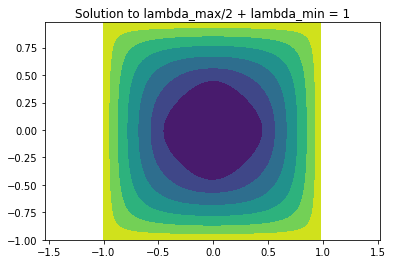

In [19]:
plt.axis('equal'); plt.title('Solution to lambda_max/2 + lambda_min = 1')
plt.contourf(X0,X1,solution);

Since the solution is not explicit, we use the non-monotone numerical scheme to test the result.
We eliminate a layer around the neighborhood of the boundary conditions, where the solution is not smooth.

Max cross-residue of the sampling based numerical solution: 0.07255245630687623


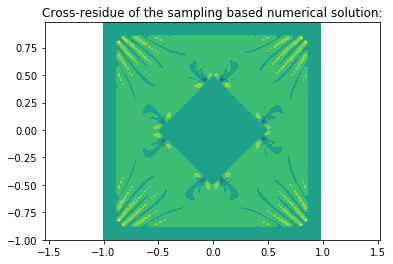

In [20]:
residue_non_monotone = SchemeNonMonotone(solution,alpha,beta,bc,gridScale)
residue_non_monotone[BoundaryNeighborhood(bc,width=5)] = 0.
print("Max cross-residue of the sampling based numerical solution:",LInfNorm(residue_non_monotone))
plt.axis('equal'); plt.title("Cross-residue of the sampling based numerical solution:")
plt.contourf(X0,X1,residue_non_monotone);

### 2.1 Limit case : $\alpha=1$.

If one chooses $\alpha=1$, then the PDE becomes linear, namely $-\Delta u + \beta = 0$.
In this very specific case, the sampling based and non-monotone scheme coincide, with the usual discretization of the laplacian operator.
As a result the Newton method converges in one iteration, and the cross-residue vanishes.

Iteration : 1 , Residue norm : 6.366684957015423e-12


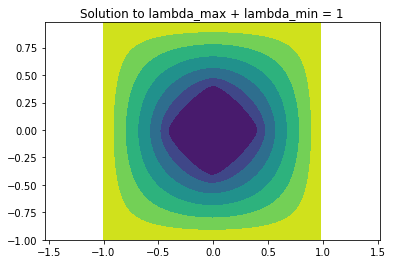

In [21]:
alpha2=1
params = (Diff(alpha2,thetas), beta,bc,gridScale)
solution = solve_Newton(SchemeSampling,params,guess,print_period=2,niter=2)

plt.axis('equal'); plt.title('Solution to lambda_max + lambda_min = 1')
plt.contourf(X0,X1,solution);

In [22]:
print("Cross residue in special case alpha=1 :", LInfNorm(SchemeNonMonotone(solution,alpha2,beta,bc,gridScale)) )

Cross residue in special case alpha=1 : 2.5011104298755527e-12


### 2.2 Limit case : $\alpha \to 0$

In contrast, if one chooses a very small value of $\alpha$, then the PDE becomes more and more non-linear, which raises numerical difficulties discussed below.
If in addition $\beta = 0$, then we recover PDE characterization of the convex envelope:
$$
    -\lambda_{\min}(\nabla^2 u) = 0
$$

**Numerical challenges.** 
As $\alpha\to 0$, the condition number of the tensors $D_\alpha(\theta)$ increase. A finer sampling of the interval $[0,\pi]$ is required, which increases the numerical cost of the method.
In addition, the width of the discretization stencil increases, and therefore the effective discretization scale is reduced.

**Note on computing the convex envelope.**
The computation of convex envelopes is one of the most central problems in algorithmic geometry. For instance, Voronoi diagrams are deduced from a convex envelope computation in higher dimension.
Extremely efficient software packages are available for this problem, and PDE methods are *not* the recommended way to go.

In [23]:
alpha_small = 0.01
ntheta_small = 50
thetas_small = np.linspace(0,np.pi,ntheta_small,endpoint=False)
beta_cvx_env = 0.

The above parameters turn the solution into the convex envelope of the boundary conditions. Recall that we imposed:
* $u=0$ on the (exterior) square boundary.
* $u=-1$ on the (interior) diamond boundary.

Iteration : 1 , Residue norm : 596.9051799892471
Iteration : 5 , Residue norm : 0.9353900056267848
Iteration : 9 , Residue norm : 0.0005874729901790961
Iteration : 13 , Residue norm : 9.059476861011716e-05
Iteration : 14 , Residue norm : 6.74161340430146e-05


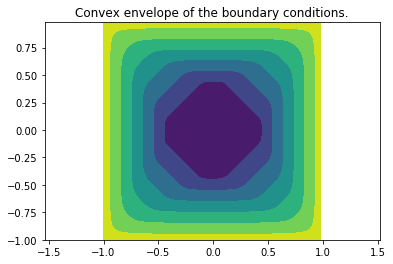

In [24]:
params = (Diff(alpha_small,thetas_small), beta_cvx_env,bc,gridScale) 
solution = solve_Newton(SchemeSampling,params,guess,print_period=4,niter=15)
plt.axis('equal'); plt.title('Convex envelope of the boundary conditions.')
plt.contourf(X0,X1,solution);

The solution is piecewise affine, and its gradient is piecewise constant.
Note in particular that the solution is not twice differentiable, and the equation $-\lambda_{\min}(\nabla^2 u) = 0$ here only has meaning in the sense of viscosity solutions.

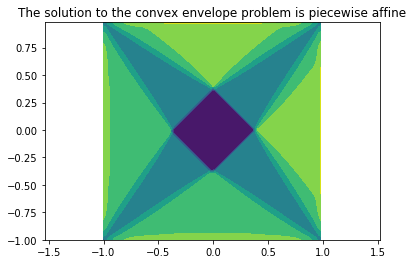

In [25]:
grad = np.array(np.gradient(solution,gridScale))
plt.axis('equal'); plt.title("The solution to the convex envelope problem is piecewise affine")
plt.contourf(X0,X1,np.linalg.norm(grad,axis=0));

We next negate the boundary conditions, imposing:
* $u=0$ on the (exterior) square boundary.
* $u=1$ on the (interior) diamond boundary.

This raises an apparent incompatibility: the convex envelope should be $u=0$ on the whole square, yet we impose a distinct value in the diamond. What to expect ?

In [26]:
bc_negated = -bc

Iteration : 1 , Residue norm : 844.9002191853244
Iteration : 5 , Residue norm : 113.95018107600596
Iteration : 9 , Residue norm : 16.080289254692186
Iteration : 13 , Residue norm : 2.1815882433884326e-13
Iteration : 14 , Residue norm : 2.1338486533295509e-13


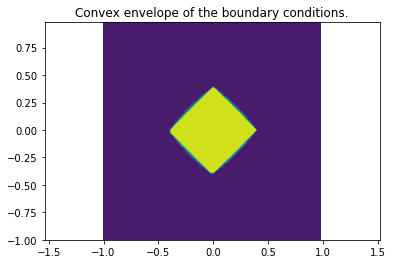

In [27]:
params = (Diff(alpha_small,thetas_small), beta_cvx_env,bc_negated,gridScale) 
solution = solve_Newton(SchemeSampling,params,guess,print_period=4,niter=15)
plt.axis('equal'); plt.title('Convex envelope of the boundary conditions.')
plt.contourf(X0,X1,solution);

The solution to the second order PDE $-\lambda_{\min}(\nabla^2 u)$ is still unique and well defined, in the sense of *viscosity solutions*, with these boundary conditions. It is piecewise constant, with value $u=0$ except on the interior diamond where we impose $u=-1$.

### 2.3 Optimization opportunities

The numerical scheme implemented in this section involves a maximization over a set of diffusion tensors. The size of this set dictates the accuracy of the method, and it may therefore become rather large. In combination with the overhead of sparse AD, this can increase the numerical cost.

We can significantly limit the numerical cost using a technique based on the *envelope theorem*, which proceeds in two steps:
* First run the scheme with ordinary floats, to find out which tensor is active at each grid point.
* Second, run the scheme with AD variables, and and *oracle* providing the active tensors.

**Important : other optimization opportunities.** 
The "optimization" presented in this subsection only serves to illustrate the envelope theorem mechanism. It is *not* effective in terms of computation time, because the optimized part is not dominant. There are other optimization opportunities here, the most obvious one being to avoid recomputing the tensor decompositions at each call of the iterative solver. The choice of linear solver may also be of importance.

In [50]:
def SchemeSampling_OptInner(u,diffs,gridScale,oracle=None):
    # Select the active tensors, if they are known
    if not(oracle is None):
        diffs = np.take_along_axis(diffs, np.broadcast_to(oracle,diffs.shape[:2]+(1,)+oracle.shape),axis=2)
        
    print("Has AD information :", ad.is_ad(u), ". Number active tensors per point :", diffs.shape[2])
    
    # Tensor decomposition 
    coefs,offsets = Selling.Decomposition(diffs)
    
    # Return the minimal value, and the minimizing index
    return ad.min_argmin( (coefs*fd.Diff2(u,offsets,gridScale)).sum(0), axis=0)

def SchemeSampling_Opt(u,diffs,beta,bc,gridScale):
    # Evaluate the operator using the envelope theorem
    result,_ = ad.apply(SchemeSampling_OptInner, u,as_field(diffs,u.shape),gridScale, envelope=True)
        
    # Boundary conditions
    return ad.where(np.isnan(bc), beta - result, u-bc)

In [51]:
params = (Diff(alpha,thetas), beta,bc,gridScale)
solution = solve_Newton(SchemeSampling_Opt,params,guess,print_period=2)

Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration : 1 , Residue norm : 96.14257029887642
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration : 3 , Residue norm : 0.3605795761342847
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Has AD information : False . Number active tensors per point : 20
Has AD information : True . Number active tensors per point : 1
Iteration : 5 , Residue norm : 0.0021915556520752943
Has AD information : False . Number active tensors per point : 20
Ha

## 3. Monotone and consistent discretization

Setting up a monotone and consistent discretization requires a bit more work, but is worthwhile in the end if performance and accuracy are a target. Let us recall that the diffusion tensors take the form,
$$
    D_\alpha(\theta) = \alpha\, e(\theta) e(\theta)^T + e(\theta)^\perp (e(\theta)^\perp)^T,
$$
where $0< \alpha \leq 1$ is a fixed parameter in the following, and $\theta \in [0,\pi]$. 

### 3.1 Angular sectors and obtuse superbases
The first, and main, difficulty is to construct a sequence of angles $0 = \theta_0 \leq \cdots \leq \theta_N = \pi$ and of superbases $s_0,\cdots, s_{N-1}$ such that 
$$
    s_k \text{ is } D_\theta(\theta) \text{-obtuse, for all } \theta \in [\theta_k, \theta_{k+1}].
$$
For that purpose, we remark that 
$$
    D_\alpha(\theta) = D_0 + D_1 \cos(2 \theta) + D_2 \sin(2 \theta),
$$
where 
$$
    D_0 = \frac{\alpha+1} 2
    \begin{pmatrix}
    1 & 0\\
    0 & 1
    \end{pmatrix},
    \quad 
    D_1 = \frac{\alpha-1} 2
    \begin{pmatrix}
    1 & 0\\
    0 &-1
    \end{pmatrix},
    \quad 
    D_2 = \frac{\alpha-1} 2
    \begin{pmatrix}
    0 & 1\\
    1 & 0
    \end{pmatrix}.
$$
Then, for given $u,v \in R^2$, one has 
$$
    <u,D_\alpha(\theta) v> = a_0 + a_1 \cos(2 \theta) + a_2 \sin(2 \theta)
    = r (\cos(2\theta-\phi) - c).
$$
where $a_i = <u,D_i v>$. Then $r e(\phi) = (a_1,a_2)$, and $c=-a_0/r$. We assume that $r$ is positive.
Eventually, the above scalar product is 
* always negative if $c>1$.
* always positive if $c<-1$.
* otherwise, positive iff $|2 \theta-\phi| \leq \arccos(c)$.

In [26]:
def MakeD(alpha):
    return np.moveaxis(0.5*np.array([
        (alpha+1)*np.array([[1,0],[0,1]]),
        (alpha-1)*np.array([[1,0],[0,-1]]),
        (alpha-1)*np.array([[0,1],[1,0]])
    ]), 0,-1)

def NextAngleAndSuperbase(theta,sb,D):
    pairs = np.stack([(1,2), (2,0), (0,1)],axis=1)
    scals = lp.dot_VAV(np.expand_dims(sb[:,pairs[0]],axis=1), 
                       np.expand_dims(D,axis=-1), np.expand_dims(sb[:,pairs[1]],axis=1))
    phi = np.arctan2(scals[2],scals[1])
    cst = -scals[0]/np.sqrt(scals[1]**2+scals[2]**2)
    theta_max = np.pi*np.ones(3)
    mask = cst<1
    theta_max[mask] = (phi[mask]-np.arccos(cst[mask]))/2
    theta_max[theta_max<=0] += np.pi
    theta_max[theta_max<=theta] = np.pi
    k = np.argmin(theta_max)
    i,j = (k+1)%3,(k+2)%3
    return (theta_max[k],np.stack([sb[:,i],-sb[:,j],sb[:,j]-sb[:,i]],axis=1))

def AnglesAndSuperbases(D,maxiter=200):
    sb = Selling.CanonicalSuperbase(2).astype(int)
    thetas=[]
    superbases=[]
    theta=0
    for i in range(maxiter):
        thetas.append(theta)
        if(theta>=np.pi): break
        superbases.append(sb)
        theta,sb = NextAngleAndSuperbase(theta,sb,D)
    return np.array(thetas), np.stack(superbases,axis=2)

The above code is a bit intricate, but its purpose is simple : split the interval $[0,\pi]$ into sub-intervals on which the support of Selling's decomposition of the tensors is fixed and known.

In [27]:
alpha=0.1
thetas,superbases = AnglesAndSuperbases(MakeD(alpha))

In [28]:
thetas

array([0.        , 0.12912139, 0.65627678, 0.91451955, 1.44167494,
       1.57079633, 1.69991771, 2.2270731 , 2.48531588, 3.01247127,
       3.14159265])

In [29]:
superbases

array([[[-1, -1, -1,  0,  0,  1,  0,  0, -1, -1],
        [ 1, -1,  1,  1, -1,  0,  1, -1, -1,  1],
        [ 0,  2,  0, -1,  1, -1, -1,  1,  2,  0]],

       [[-1, -1, -1,  1,  1,  0, -1, -1,  1,  1],
        [ 0,  0,  0,  1, -1, -1, -1,  1,  0,  0],
        [ 1,  1,  1, -2,  0,  1,  2,  0, -1, -1]]])

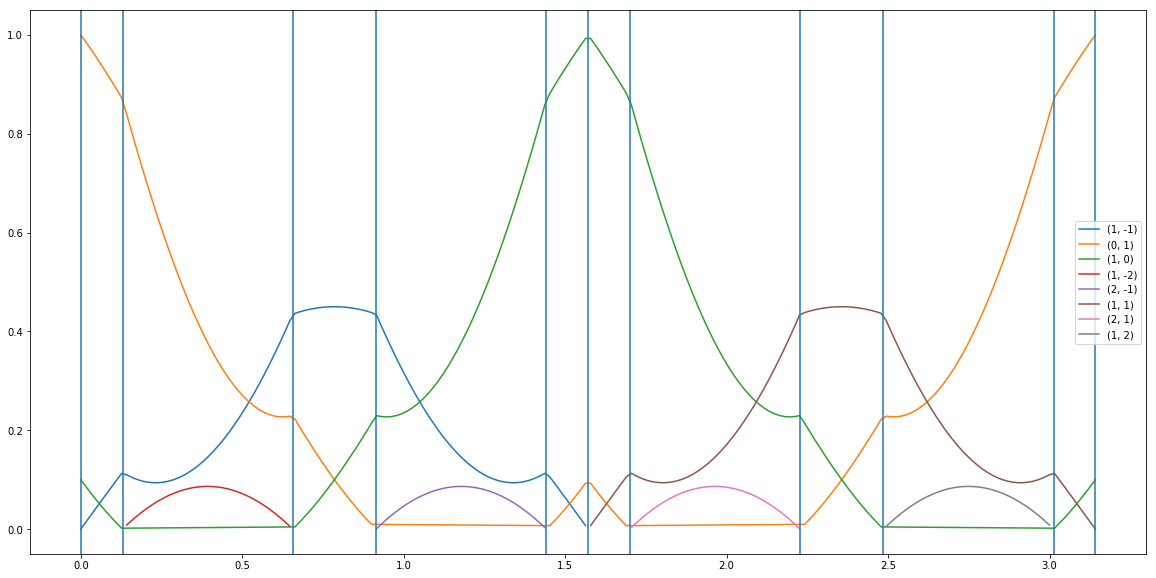

In [36]:
thetas_sampled = np.linspace(0,np.pi,200)
decomp = Selling.GatherByOffset(thetas_sampled,*Selling.Decomposition(Diff(alpha,thetas_sampled)))

plt.figure(figsize=(20,10))
for offset,(angle,coef) in decomp.items():
    plt.plot(angle,coef)
plt.legend(decomp.keys());

for theta in thetas: # Show a vertical line for each angle theta where the stencil changes
    plt.axvline(x=theta);

### 3.2 Optimization over angular sector

The second step is discretize 
$$
    \min_{\theta \in [\theta_0,\theta_1]} {\rm Tr}(D_\alpha(\theta) \nabla^2 u(x)),
$$
when $D_\alpha(\theta)$ admits the same known obtuse superbase $b = (b_0,b_1,b_2)$ for each $\theta \in [\theta_0,\theta_1]$.

The discretization reads
$$
    \min_{\theta \in [\theta_0, \theta_1]} - \sum_{1 \leq i \leq 3} <b_{i+1}, D_\alpha(\theta) b_{i+1}> \frac{u(x+h b_i^\perp)-2 u(x) + u(x-h b_i^\perp)}{h^2}.
$$

For that purpose, we rely on the expression $D_\alpha(\theta) = D_0 + D_1 \cos(2 \theta) + D_2 \sin(2 \theta)$, and on the explicit solution 
$$
    \min_{\phi \in [2\theta_0,2\theta_1]} d_0 + d_1 \cos \phi + d_2 \sin \phi = d_0 - \sqrt{d_1^2+d_2^2}
$$
if $(\cos \phi,\sin \phi)$ is proportional to $-(d_1,d_2)$ for some $\phi \in [2\theta_0,2\theta_1]$. Otherwise the minimum is attained at $2\theta_0$ or $2 \theta_1$.

In [264]:
def MinimizeTrace(u,theta0,theta1,D,sb,h):
    d2u = fd.diff2(u,np.array([-sb[1],sb[0]]),h)
    pairs = np.stack([(1,2), (2,0), (0,1)],axis=1)
    scals = lp.dot_VAV(np.expand_dims(sb[:,pairs[0]],axis=1), 
                       np.expand_dims(D,axis=-1), np.expand_dims(sb[:,pairs[1]],axis=1))
    #TODO : dims
    coefs = -scals*d2u
    value = coefs[0] - np.sqrt(coefs[0]**2+coefs[1]**2)
    angle = np.arctan2(-coefs[1],-coefs[0])/2
    angle[angle<0]+=np.pi
    mask = np.logical_not(np.logical_and(theta0<=angle,angle<=theta1))
    t0,t1,c = theta0[mask],theta1[mask],coefs[:,mask]
    value[mask] = c[0] + np.minimum(c[1]*np.cos(2*t0)+c[2]*np.sin(2*t0),c[1]*np.cos(2*t1)+c[2]*np.sin(2*t1))
    return value

def Scheme(u,alpha,beta,bc,h):
    D=MakeD(alpha)
    thetas,sb = AnglesAndSuperbases(D)
    residue = beta - MinimizeTrace(thetas[:-1],thetas[1:],D,sb,u,h)
    return ad.where(np.isnan(bc),residue,u-bc)

In [119]:
Diff(alpha,0.5)

array([[ 0.38387908, -0.33658839],
       [-0.33658839,  0.81612092]])

In [123]:
(1+np.sqrt(2))**2

5.82842712474619

In [189]:
1/(1+np.sqrt(2))**2

0.1715728752538099

In [263]:
np.maximum(2,1)

2